In [235]:
import pysam
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.nonparametric.smoothers_lowess as sl

from statsmodels.stats.multitest import fdrcorrection
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [236]:
# load bam file:
bam = pysam.AlignmentFile("/Users/davidangeles/repos/tnseq/aligned/sorted.aligned.bam", "rb")

# load annotations
gff = pd.read_csv('/Users/davidangeles/PA14/ensembl/Pseudomonas_aeruginosa_ucbpp_pa14_gca_000014625.ASM1462v1.51.chromosome.Chromosome.gff',
                  sep='\t', comment='#')
gff.columns = ['Chromosome', 'NaN', 'Type', 'Pos1', 'Pos2', '.', 'Strand', 'Unk', 'FeatureDescription']
gff['Description'] = gff.FeatureDescription.str.split('description=', expand=True)[1].str.split(';', expand=True)[0]
gff['HumanReadableName'] = gff.FeatureDescription.str.split('Name=', expand=True)[1].str.split(';', expand=True)[0]
gff['TxName'] = gff.FeatureDescription.str.split(';', expand=True)[0].str.replace('ID=transcript:', '')
gff["AvgPos"] = (gff.Pos1 + gff.Pos2) / 2

In [237]:
def count_mutants(bam):
    """
    Generate a dictionary of reads that align at a specific
    """
    iter = bam.fetch()
    idx = {}
    for x in iter:
        if x.is_reverse == False:
            key = x.reference_start
        else:
            key = x.reference_end

        try:
            idx[key] += 1
        except:
            idx[key] = 1
    return idx

def correct_muts(idx):
    found = []
    for k in idx.keys():
        try:
            v = idx[k + 1]
            found += [k + 1]
        except:
            continue
    return len(found)

In [238]:
bam = pysam.AlignmentFile("/Users/davidangeles/repos/tnseq/aligned/sorted.aligned.bam", "rb")
idx = count_mutants(bam)
close = correct_muts(idx)
print('To a first approximation, there appear to be around {0:.1e} mutants in this library'.format(len(idx.keys())))
print('There are around {0:.1e} reads with 5\' insertions within 1bp of an upstream insertion'.format(close))
print('Lower bound for mutants: {0:.1e}'.format(len(idx.keys()) - close))
print('There is an insertion every {0} bp on average'.format(int(np.floor(6 * 10 ** 6 / (len(idx.keys()) - close)))))

To a first approximation, there appear to be around 2.4e+05 mutants in this library
There are around 5.6e+04 reads with 5' insertions within 1bp of an upstream insertion
Lower bound for mutants: 1.9e+05
There is an insertion every 32 bp on average


In [241]:
gff['Bin'] = pd.IntervalIndex.from_tuples(gff.apply(lambda x: (x.Pos1 + 10, x.Pos2 - 10), axis=1))
to_use = gff[gff.Type == 'gene'].copy().reset_index(drop=True)

AvgPos = to_use[['Pos1', 'Pos2']].apply(np.mean, axis=1)
Size = to_use[['Pos1', 'Pos2']].apply(lambda x: np.abs(x.Pos1 - x.Pos2), axis=1)
Name = to_use.HumanReadableName

overlaps = {}
for i, bracket in enumerate(to_use['Bin']):
    any_overlaps = False
    for j, bracket2 in enumerate(to_use['Bin'][i + 1:i + 10]):
        if bracket.overlaps(bracket2):
            overlaps[i] = True
            any_overlaps = True
        break
    if any_overlaps == False:
        overlaps[i] = False

to_use['Overlaps'] = to_use.index.map(overlaps)
to_use['BinSize'] = pd.IntervalIndex(to_use.Bin).length
to_use['BinMidPos'] = pd.IntervalIndex(to_use.Bin).mid
to_use = to_use[to_use.Overlaps == False]

,Chromosome,NaN,Type,Pos1,Pos2,.,Strand,Unk,FeatureDescription,Description,HumanReadableName,TxName,AvgPos,Bin,Overlaps,BinSize,BinMidPos
0,Chromosome,ena,gene,483,2027,.,+,.,ID=gene:PA14_00010;Name=dnaA;biotype=protein_c...,chromosomal replication initiator protein DnaA,dnaA,ID=gene:PA14_00010,1255.0,"(493, 2017]",False,1524,1255.0
1,Chromosome,ena,gene,2056,3159,.,+,.,ID=gene:PA14_00020;Name=dnaN;biotype=protein_c...,DNA polymerase III%2C beta chain,dnaN,ID=gene:PA14_00020,2607.5,"(2066, 3149]",False,1083,2607.5
2,Chromosome,ena,gene,3169,4278,.,+,.,ID=gene:PA14_00030;Name=recF;biotype=protein_c...,DNA replication and repair protein RecF,recF,ID=gene:PA14_00030,3723.5,"(3179, 4268]",False,1089,3723.5
3,Chromosome,ena,gene,4275,6695,.,+,.,ID=gene:PA14_00050;Name=gyrB;biotype=protein_c...,DNA gyrase subunit B,gyrB,ID=gene:PA14_00050,5485.0,"(4285, 6685]",False,2400,5485.0
4,Chromosome,ena,gene,7018,7791,.,-,.,ID=gene:PA14_00060;biotype=protein_coding;desc...,putative acyltransferase,None,ID=gene:PA14_00060,7404.5,"(7028, 7781]",False,753,7404.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5887,Chromosome,ena,gene,6530561,6532453,.,-,.,ID=gene:PA14_73370;Name=gidA;biotype=protein_c...,glucose-inhibited division protein A,gidA,ID=gene:PA14_73370,6531507.0,"(6530571, 6532443]",False,1872,6531507.0
5888,Chromosome,ena,gene,6532927,6533310,.,-,.,ID=gene:PA14_73390;biotype=protein_coding;desc...,hypothetical protein,None,ID=gene:PA14_73390,6533118.5,"(6532937, 6533300]",False,363,6533118.5
5889,Chromosome,ena,gene,6533634,6535001,.,-,.,ID=gene:PA14_73400;Name=thdF;biotype=protein_c...,putative GTPase for tRNA modification and thio...,thdF,ID=gene:PA14_73400,6534317.5,"(6533644, 6534991]",False,1347,6534317.5
5890,Chromosome,ena,gene,6535072,6536808,.,-,.,ID=gene:PA14_73410;Name=yidC;biotype=protein_c...,putative inner membrane protein%2C 60 kDa,yidC,ID=gene:PA14_73410,6535940.0,"(6535082, 6536798]",False,1716,6535940.0


In [955]:
# make mutants from dictionary:
mutants = pd.DataFrame.from_dict(idx, orient='index').reset_index()
mutants.columns = ['Position', 'Frequency']
mutants.sort_values('Position', inplace=True)

# binned data:
GroupBin = pd.cut(mutants.Position, pd.IntervalIndex(to_use.Bin))

# normalized frequency:
mutants['NormFreq'] = mutants.Frequency / mutants.Frequency.sum() * 10 ** 6

# total reads per gene:
mutants['PerBinSum'] = mutants.groupby(GroupBin).Frequency.transform(np.sum)
# total mutants per gene:
mutants['PerBinCount'] = mutants.groupby(GroupBin).Frequency.transform('count')

# # keep only non nan entries:
subset = mutants.dropna().copy()

# annotate bins:
GroupBin = pd.cut(subset.Position, pd.IntervalIndex(to_use.Bin))
grouped = subset.groupby(GroupBin)

keys = {p: key for (key, _) in grouped for p in _.Position.values}
subset['Bin'] = subset.Position.map(keys)
subset['BinStart'] = pd.IntervalIndex(subset.Bin).left
subset['BinSize'] = pd.IntervalIndex(subset.Bin).length
subset['BinMidPos'] = pd.IntervalIndex(subset.Bin).mid

# add annotations
subset = subset.join(to_use.set_index('Bin')[['Description', 'HumanReadableName']], on='Bin')

# # keep only genes with at least 3 mutants in them:
subset = subset[subset.PerBinCount > 1]

# # allele frequency per gene:
subset['AlleleFreq'] = subset.Frequency / subset.PerBinSum


# mutants per kbp per gene:
subset['PerBinCountPerKbp'] = subset.PerBinCount / subset.BinSize * 10 ** 3

# position of the Tn along the gene body
subset['GeneBodyPos'] = (subset.Position -  subset.BinStart) / subset.BinSize

# annotate!
subset.sort_values('Position').head()
subset = subset.rename(columns={'HumanReadableName': 'Gene'})
subset.head()

,Position,Frequency,NormFreq,PerBinSum,PerBinCount,Bin,BinStart,BinSize,BinMidPos,Description,Gene,AlleleFreq,PerBinCountPerKbp,GeneBodyPos
23,3231,1,0.205174,490.0,22.0,"(3179, 4268]",3179,1089,3723.5,DNA replication and repair protein RecF,recF,0.002041,20.20202,0.047750
22,3233,56,11.489739,490.0,22.0,"(3179, 4268]",3179,1089,3723.5,DNA replication and repair protein RecF,recF,0.114286,20.20202,0.049587
24,3235,14,2.872435,490.0,22.0,"(3179, 4268]",3179,1089,3723.5,DNA replication and repair protein RecF,recF,0.028571,20.20202,0.051423
27,3270,21,4.308652,490.0,22.0,"(3179, 4268]",3179,1089,3723.5,DNA replication and repair protein RecF,recF,0.042857,20.20202,0.083563
25,3279,33,6.770739,490.0,22.0,"(3179, 4268]",3179,1089,3723.5,DNA replication and repair protein RecF,recF,0.067347,20.20202,0.091827


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


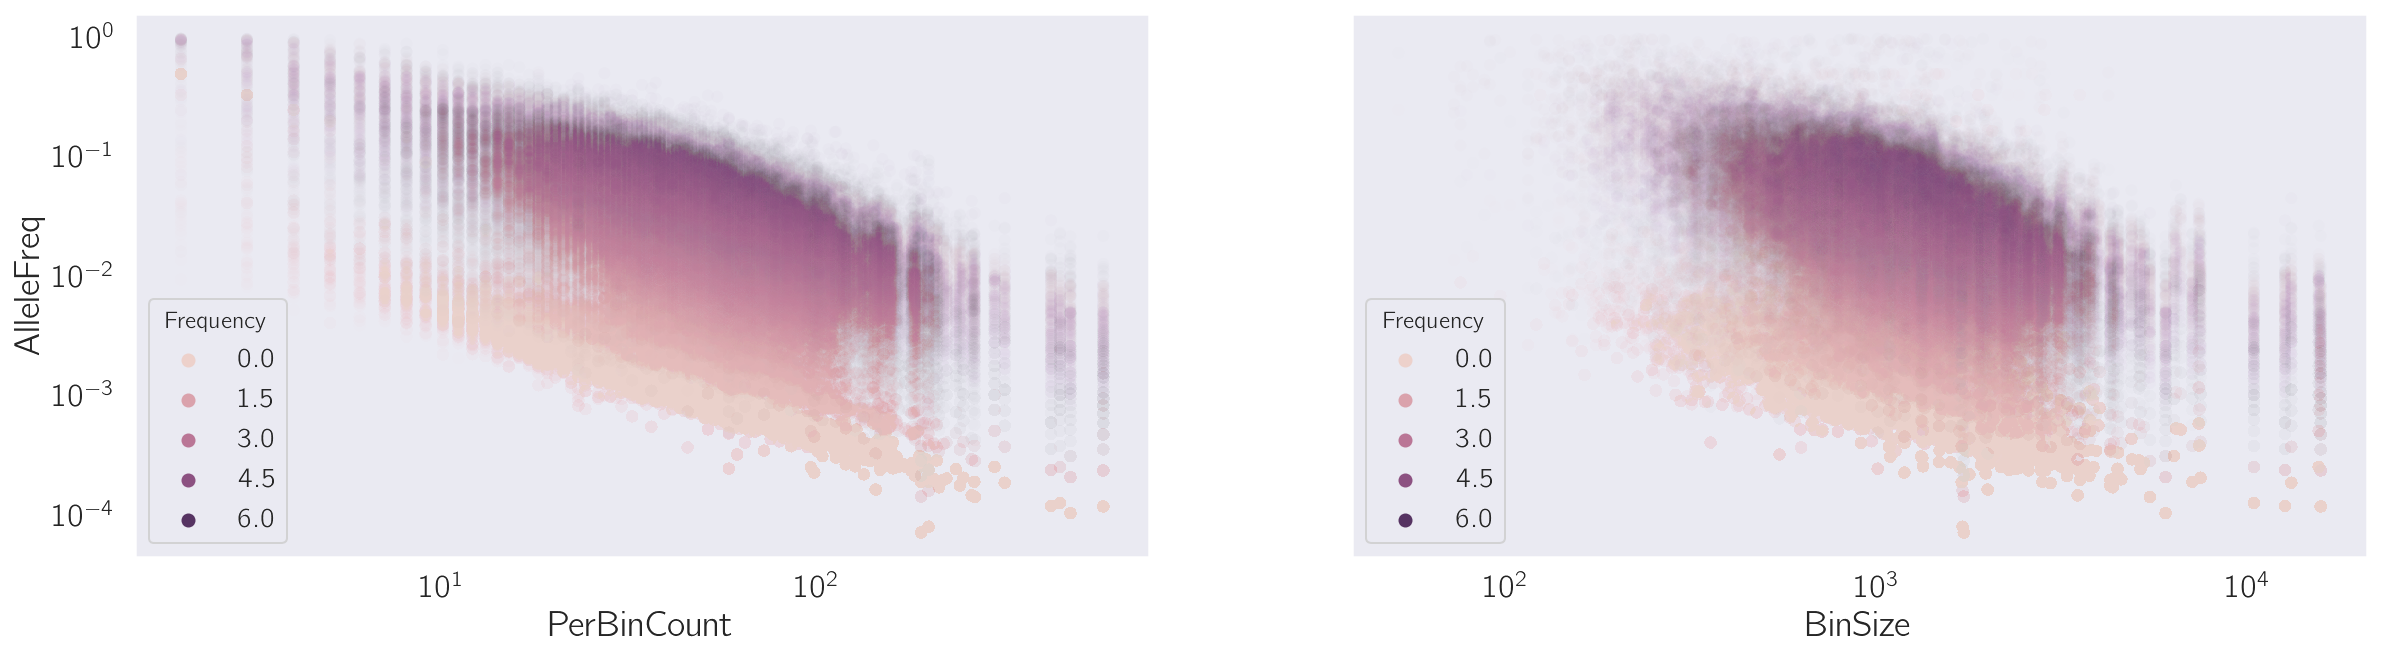

In [316]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(20, 5))
sns.scatterplot('PerBinCount', 'AlleleFreq', data=subset, hue=subset.Frequency.apply(np.log), alpha=0.01, ax=ax[0])
sns.scatterplot('BinSize', 'AlleleFreq', data=subset, hue=subset.Frequency.apply(np.log), alpha=0.01, ax=ax[1])

plt.yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')

In [973]:
cond = subset.Frequency.apply(np.log) > 2
subset['LogBinSize'] = subset.BinSize.apply(np.log10)
subset['LogAlleleFreq'] = subset.AlleleFreq.apply(np.log10)

fig, ax = plt.subplots(ncols=2, sharey=False, figsize=(20, 5))
sns.kdeplot('LogBinSize', 'LogAlleleFreq', data=subset,
            fill=True, thresh=0, levels=100, cmap="mako", ax=ax[0])
sns.kdeplot('LogBinSize', 'LogAlleleFreq', data=subset[cond],
            fill=True, thresh=0, levels=100, cmap="mako", ax=ax[1])

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


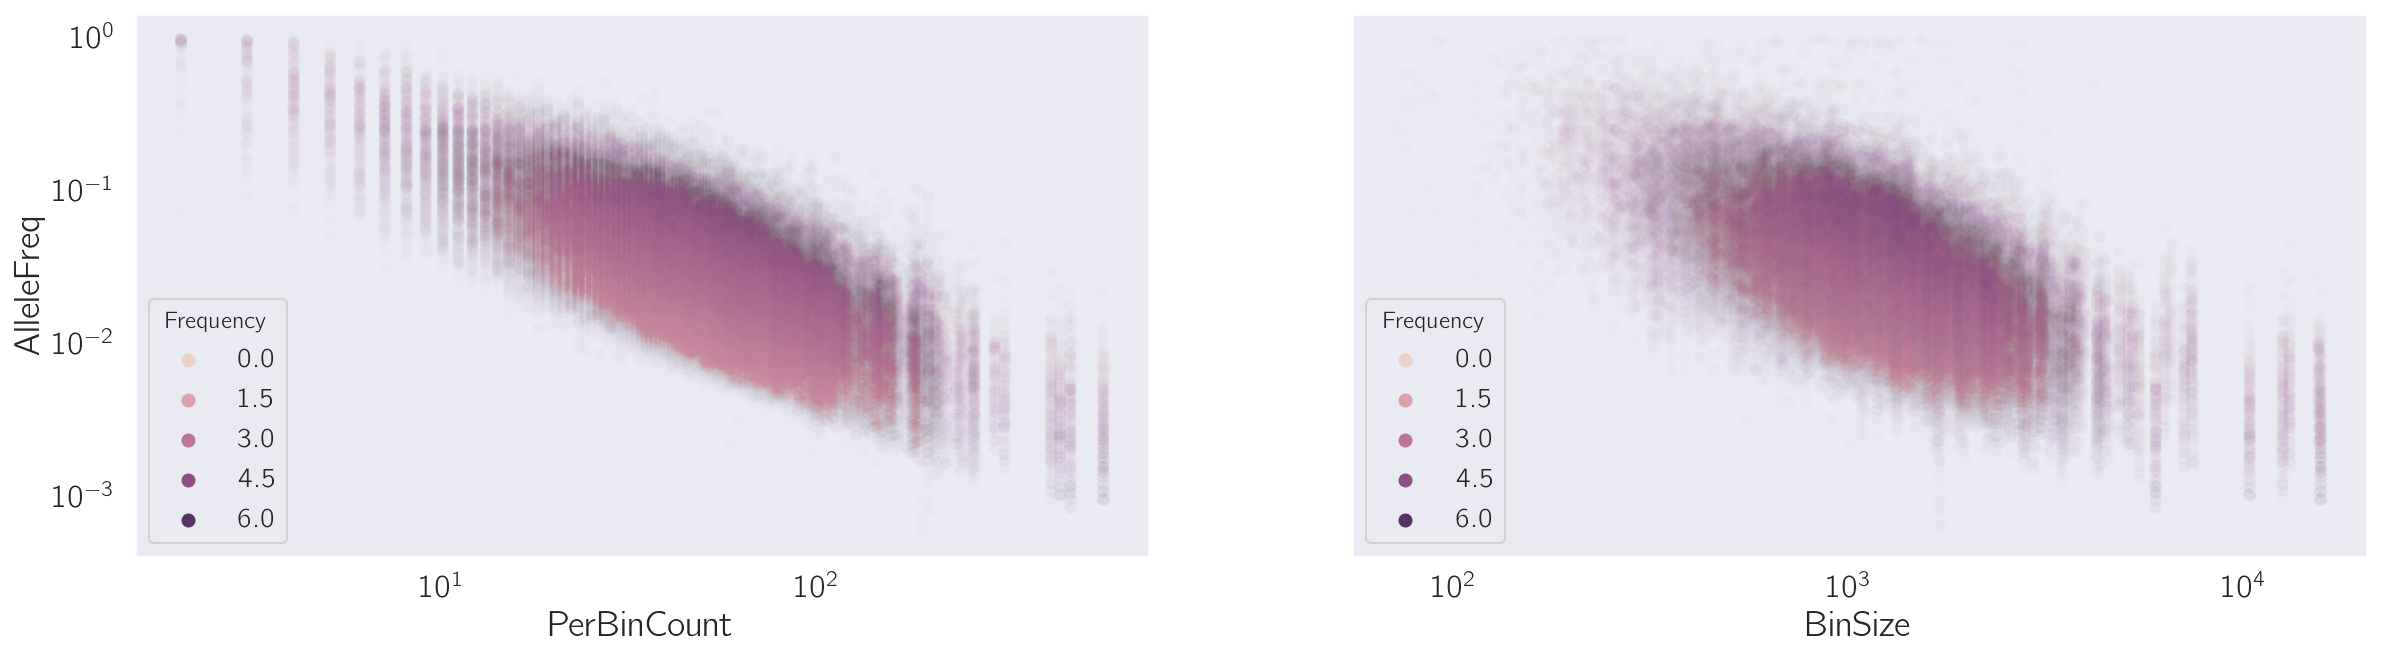

In [318]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(20, 5))

sns.scatterplot('PerBinCount', 'AlleleFreq', data=subset[cond], hue=subset.Frequency.apply(np.log), alpha=0.01, ax=ax[0])
sns.scatterplot('BinSize', 'AlleleFreq', data=subset[cond], hue=subset.Frequency.apply(np.log), alpha=0.01, ax=ax[1])

plt.yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


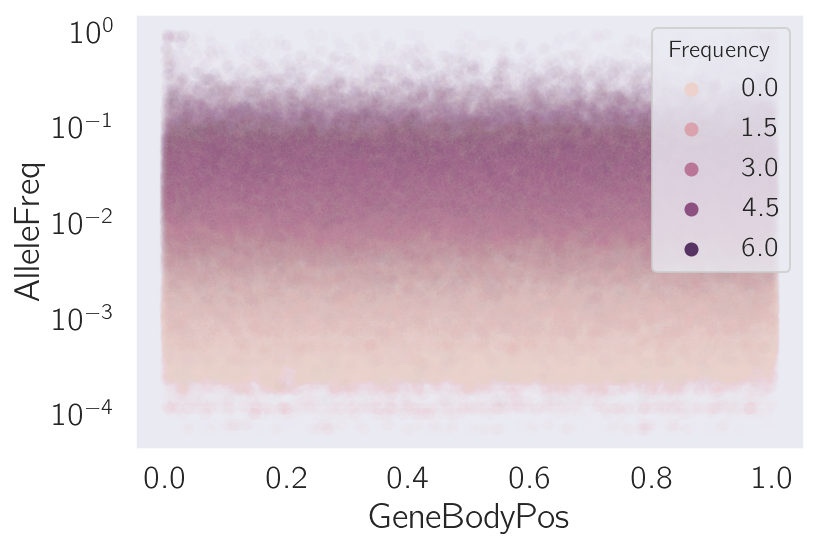

In [320]:
# colors = subset.PerBinSum / subset.PerBinSum.max()
sns.scatterplot('GeneBodyPos', 'AlleleFreq', data=subset, hue=subset.Frequency.apply(np.log), alpha=0.02)
plt.yscale('log')

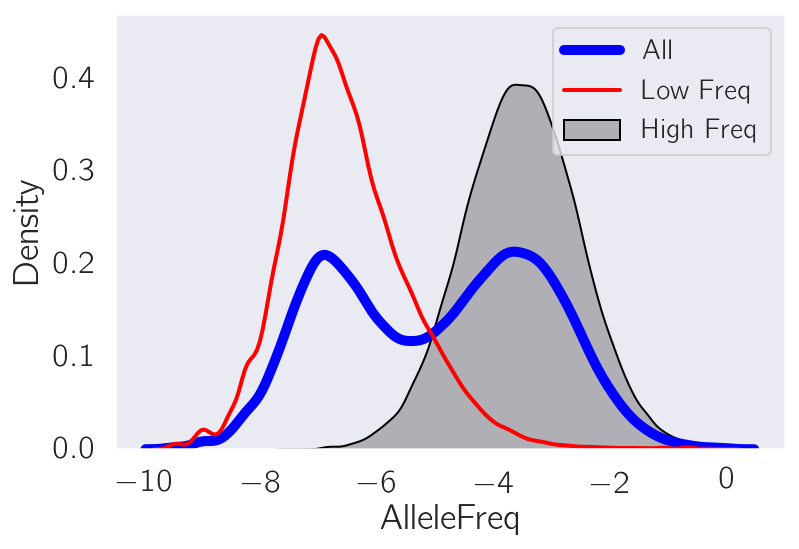

In [321]:
fig, ax = plt.subplots()
sns.kdeplot(subset.AlleleFreq.apply(np.log), label='All', lw=5, color='blue')
sns.kdeplot(subset.AlleleFreq.apply(np.log)[cond], label='High Freq', color='black', fill=True)
sns.kdeplot(subset.AlleleFreq.apply(np.log)[~cond], label='Low Freq', color='red')
plt.legend()

Var = 1


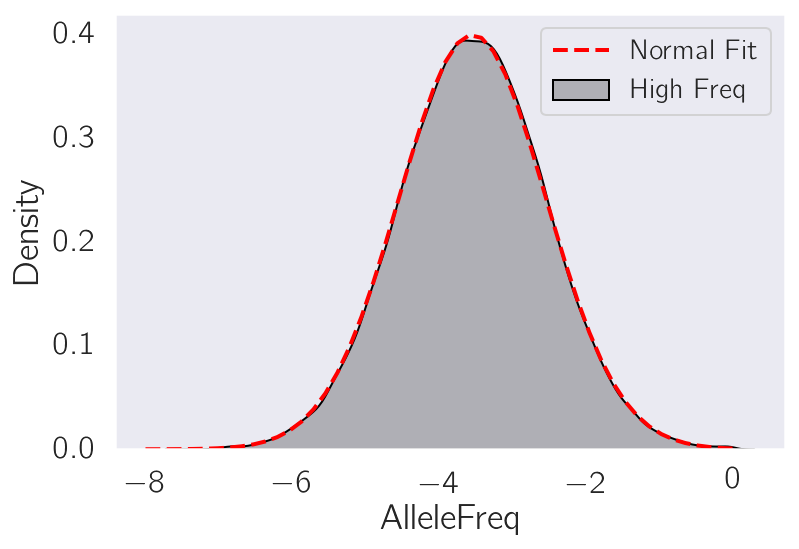

In [322]:
x = np.linspace(-8, 0)
fig, ax = plt.subplots()
sns.kdeplot(subset.AlleleFreq.apply(np.log)[cond], label='High Freq', color='black', fill=True)
plt.plot(x, scipy.stats.norm.pdf(x, loc=subset[cond].AlleleFreq.apply(np.log).mean(),
                                    scale=subset[cond].AlleleFreq.apply(np.log).var()),
        lw=2, ls='--', color='red', label='Normal Fit')
plt.legend()
print('Var = {0:.2g}'.format(subset[cond].AlleleFreq.apply(np.log).var()))

In [957]:
eff_genome_size = subset[cond].groupby('Gene').BinSize.mean().sum() 
n_mutants = subset[cond].shape[0]

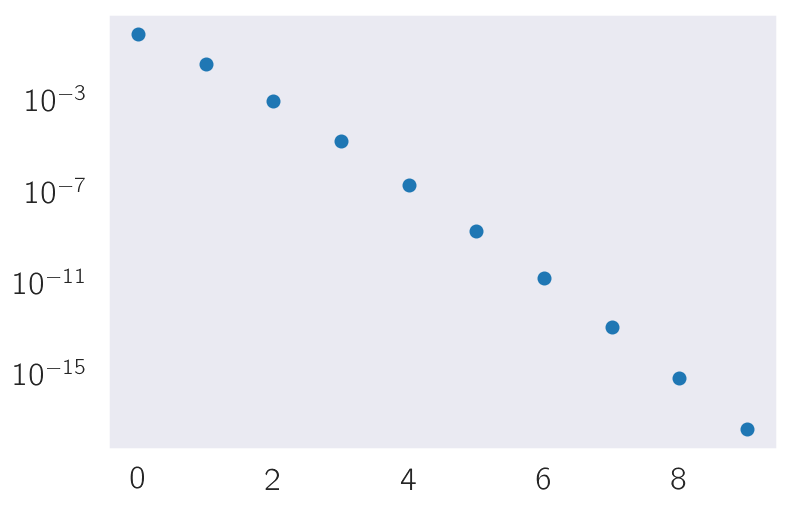

In [958]:
scale = n_mutants / eff_genome_size
x = np.arange(0, 10)
plt.scatter(x, scipy.stats.poisson.pmf(x, scale))
plt.yscale('log')

In [985]:
df = subset[cond].copy()
grouped = df.groupby('Gene')

genes = grouped.Frequency.mean()
genes = pd.DataFrame(genes)
genes['TnMutants'] = grouped.Frequency.count()
genes['TotalFreq'] = grouped.Frequency.sum()
genes['Var'] = grouped.Frequency.var()
genes['BinSize'] = grouped.BinSize.mean()
genes['GenePosition'] = grouped.BinMidPos.mean()
genes['GeneBodyCoverage'] = grouped.GeneBodyPos.apply(lambda x: np.percentile(x, 90) - np.percentile(x, 10))

genes.reset_index(inplace=True)
genes.columns = ['Gene', 'AvgFreq', 'TnMutants', 'TotalFreq', 'Var', 'BinSize', 'GenePosition', 'GeneBodyCoverage']

genes['TnInsKbp'] = genes.TnMutants / genes.BinSize * 10 ** 3
genes['log1pAvgFreq'] = genes.AvgFreq.apply(np.log1p)
genes['log1pTotFreq'] = genes.TotalFreq.apply(np.log1p)


genes.head()

,Gene,AvgFreq,TnMutants,TotalFreq,Var,BinSize,GenePosition,GeneBodyCoverage,TnInsKbp,log1pAvgFreq,log1pTotFreq
0,JF1,36.144737,76,2747,488.045439,3639.000000,7.096015e+05,0.718879,20.884858,3.614822,7.918629
1,XR2,44.250000,4,177,818.916667,186.000000,6.994860e+05,0.167204,21.505376,3.812203,5.181784
2,aat,27.733333,15,416,432.923810,660.000000,2.621115e+06,0.446364,22.727273,3.358058,6.033086
3,abc,35.074074,27,947,437.994302,987.000000,6.469050e+06,0.730294,27.355623,3.585574,6.854355
4,accC,41.830986,71,2970,914.228169,1372.478873,3.027952e+06,0.752845,51.731215,3.757262,7.996654


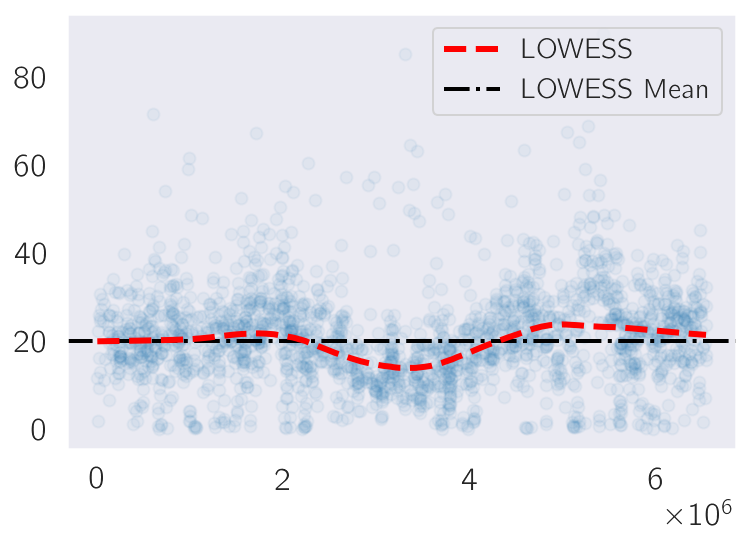

In [770]:
genes.sort_values('GenePosition', inplace=True)
y = genes.TnInsKbp
x = genes.GenePosition
lowess = sl.lowess(y, x, return_sorted=False, it=4, delta=10, frac=.3)

plt.scatter(x, y, alpha=0.05)
plt.plot(x, lowess, color='red', label='LOWESS', ls='--', lw=3, zorder=3)
plt.axhline(lowess.mean(), color='black', ls='-.', label='LOWESS Mean', zorder=2)
plt.legend()

In [994]:
genes['TnInsKbpLowessCorrected'] = genes.TnInsKbp * lowess.mean() / lowess
genes['TnMutantsCorrected'] = genes.TnInsKbpLowessCorrected * genes.BinSize / 10 ** 3
genes['ExpectedInsertions'] = genes.TnMutantsCorrected.sum() / eff_genome_size * genes.BinSize
print(genes.TnMutantsCorrected.sum() / genes.TnMutants.sum())

def test_DE(x):
    if x.TnMutantsCorrected < x.ExpectedInsertions:
        return scipy.stats.poisson.cdf(x.TnMutantsCorrected, x.ExpectedInsertions)
    else:
        return scipy.stats.poisson.sf(x.TnMutantsCorrected, x.ExpectedInsertions)

genes['pvals'] = genes.apply(test_DE, axis=1)
genes['qvals'] = fdrcorrection(genes.pvals)[1]
genes['log10q'] = - genes.qvals.apply(np.log10)

1.026920774249933


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


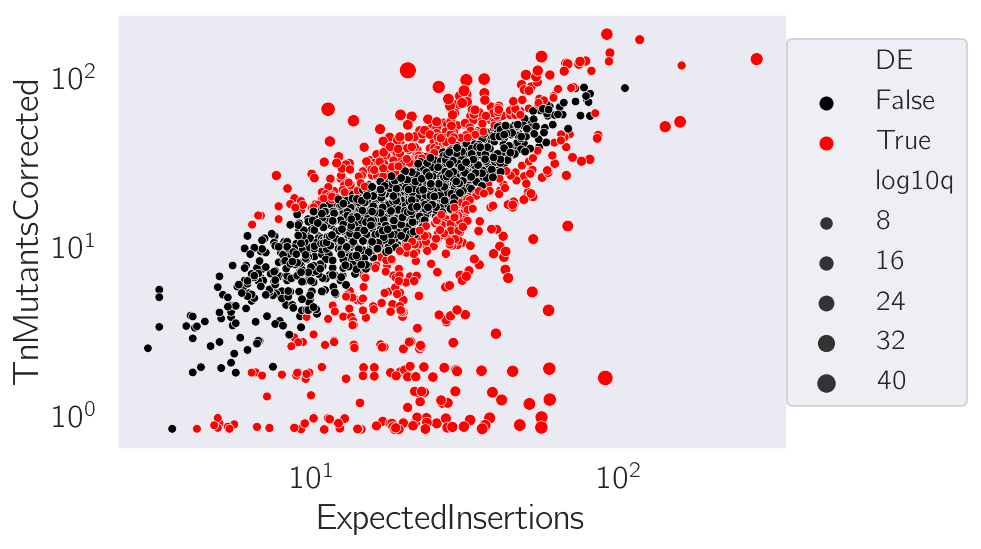

In [996]:
def result(x, threshold=0.05):
    if x.DE == True:
        if x.TnMutantsCorrected > x.ExpectedInsertions:
            return 'Enriched'
        else:
            return 'Depleted'
    else:
        return 'Normal'
    

genes['DE'] = genes.qvals < 0.05
genes['Result'] = genes.apply(result, axis=1)

sns.scatterplot('ExpectedInsertions', 'TnMutantsCorrected', hue='DE', data=genes,
                size=genes.log10q,
                hue_order=[False, True], palette=['black', 'red'])#, edgecolors=None)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(1, 0.1))

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


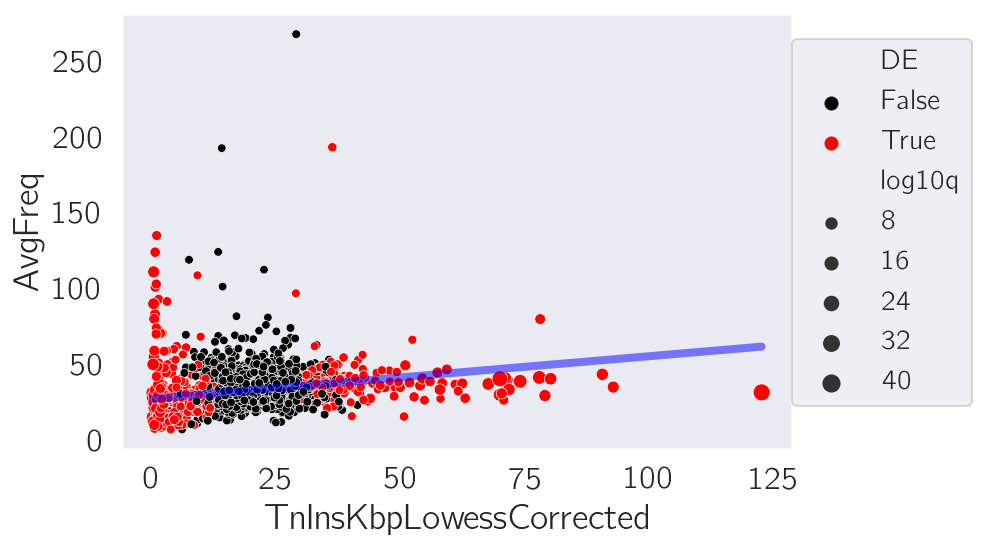

In [336]:
x = 'TnInsKbpLowessCorrected'
y = 'AvgFreq'
params = scipy.stats.siegelslopes(genes[y], genes[x])
sns.scatterplot('TnInsKbpLowessCorrected', 'AvgFreq', hue='DE', data=genes,
                size=genes.log10q,
                hue_order=[False, True], palette=['black', 'red'], )
plt.plot(genes[x].sort_values(), params[1] + params[0] * genes[x].sort_values(), color='blue', lw=4, alpha=0.5)
plt.legend(loc=(1, 0.1))

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


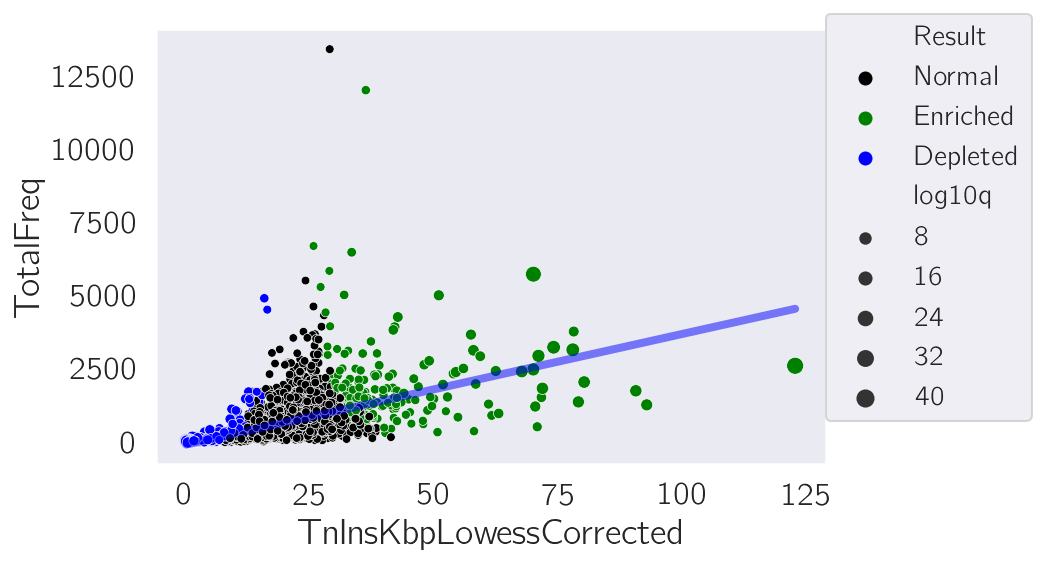

In [902]:
x = 'TnInsKbpLowessCorrected'
y = 'TotalFreq'
params = scipy.stats.siegelslopes(genes[y], genes[x])
sns.scatterplot(x, y, hue='Result', data=genes,
                size=genes.log10q,
                hue_order=['Normal', 'Enriched', 'Depleted'],
                palette=['black', 'green', 'blue'])
plt.plot(genes[x].sort_values(),
         params[1] + params[0] * genes[x].sort_values(),
         color='blue', lw=4, alpha=0.5)
plt.legend(loc=(1, 0.1))

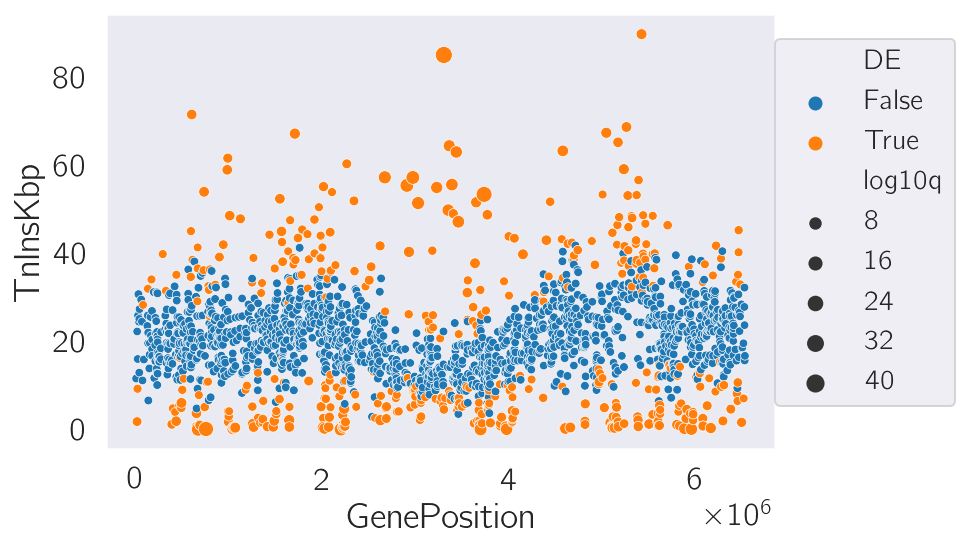

In [338]:
x = 'GenePosition'
y = 'TnInsKbp'
sns.scatterplot(x, y, hue='DE', data=genes, size=genes.log10q)
plt.legend(loc=(1, .1))

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


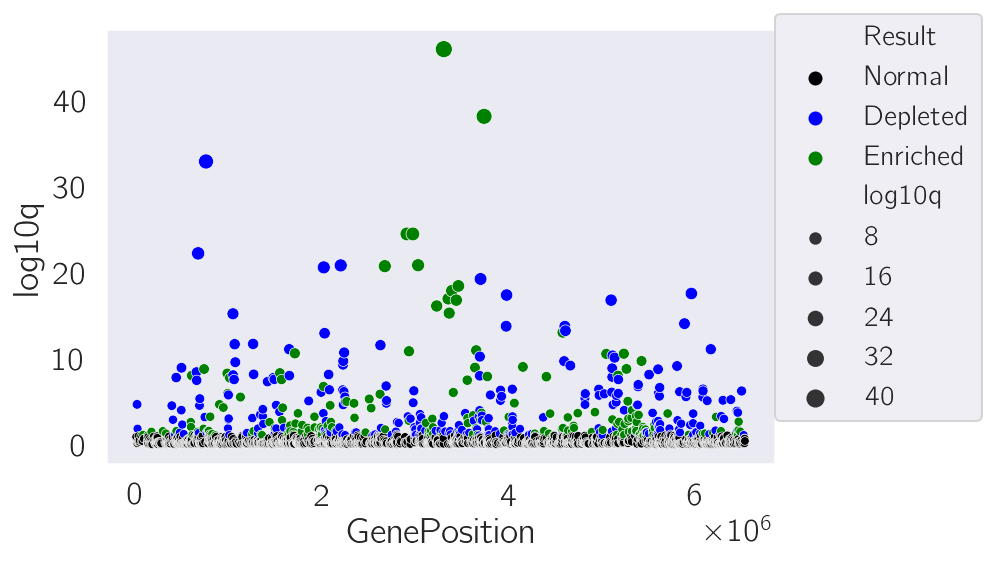

In [339]:
x = 'GenePosition'
y = 'log10q'
sns.scatterplot(x, y, hue='Result', data=genes, size=genes.log10q, hue_order=['Normal', 'Depleted', 'Enriched'],
               palette=['black', 'blue', 'green'])
# plt.plot(x, lowess, color='red', label='LOWESS', ls='--', lw=3, zorder=3)
# plt.axhline(lowess.mean(), color='black', ls='-.', label='LOWESS Mean', zorder=2)
plt.legend(loc=(1, .1))
# plt.yscale('log')

In [963]:
genes.sort_values('log10q').tail(20)[['Gene', 'TotalFreq', 'AvgFreq', 'TnMutants', 'ExpectedInsertions', 'log10q', 'Result']]

,Gene,TotalFreq,AvgFreq,TnMutants,ExpectedInsertions,log10q,Result
1484,pvdJ,1744,28.129032,62,139.787716,14.849482,Depleted
411,dnaX,30,15.000000,2,44.504106,15.644963,Depleted
963,morA,5322,40.015038,133,90.224870,16.364283,Enriched
1010,mutT,1776,44.400000,40,13.484104,16.512316,Enriched
1304,pilB,5037,50.370000,100,35.923458,16.651107,Enriched
1618,secA,189,37.800000,5,58.271563,17.467549,Depleted
1479,pvdD,1502,22.757576,66,156.372699,17.542948,Depleted
255,clpB,5759,41.431655,139,55.252258,17.983003,Enriched
845,lig,13,13.000000,1,50.459331,17.983003,Depleted
1398,priA,51,51.000000,1,46.937424,18.122429,Depleted


In [641]:
def logpoisson(x, mu):
    return  x.sum() * np.log(mu) - len(x) * mu - scipy.special.gammaln(x).sum()

def loglognormal(x, mu, sigma):
    return - len(x) / 2 * (np.log(2 * np.pi * sigma ** 2)) - 1 / sigma ** 2 * np.sum((x - mu) ** 2)

def bayesian_fit(reads, mu, mu0, sigma):
    P_datamu = logpoisson(reads, reads.sum() * mu)
    P_mumu0 = loglognormal(mu, mu0, sigma)
    return P_datamu + P_mumu0

(0.0, 79.0)

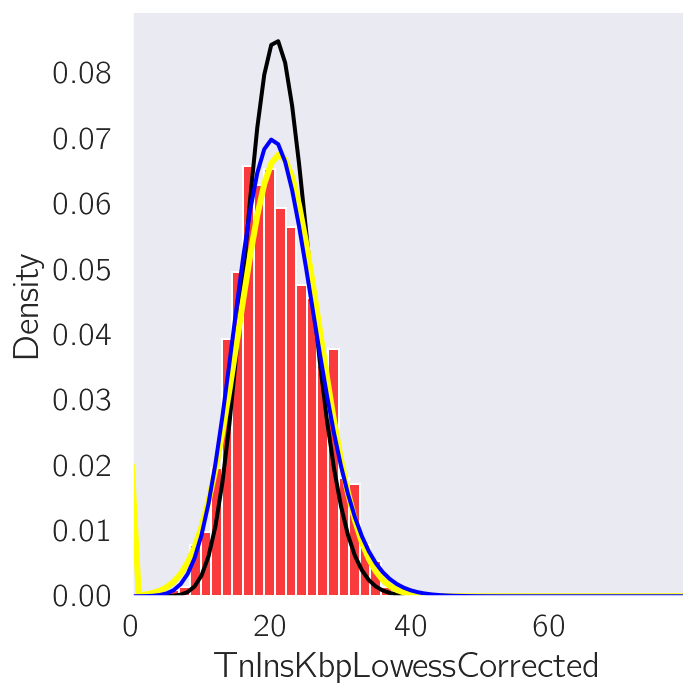

In [964]:
x = np.arange(0, 80)
pi = 0.02
col = 'TnInsKbpLowessCorrected'
cond = genes.DE == False
mean = np.mean(genes[cond][col])
lognorm_params = scipy.stats.lognorm.fit(genes[cond][col])

def ZIP(x, pi, func=scipy.stats.poisson.pmf, args={'mu': mean}):
    prob = np.zeros(x.size)
    prob[x == 0] = pi + (1 - pi) * func(x[x == 0], **args)
    prob[x > 0] = (1 - pi) * func(x[x > 0], **args)
    return prob

sns.displot(genes[cond][col], color='red', stat='density')
plt.plot(x, ZIP(x, pi), color='black')
plt.plot(x, ZIP(x, pi, func=scipy.stats.norm.pdf, args={'loc': mean, 'scale': genes[cond][col].std()}), color='yellow', lw=3)
plt.plot(x, ZIP(x, 0, func=scipy.stats.lognorm.pdf,
                args={'s': lognorm_params[0],
                      'loc': lognorm_params[1],
                      'scale': lognorm_params[2]}),
         color='blue')
plt.xlim(x.min(), x.max())

(0.0, 79.0)

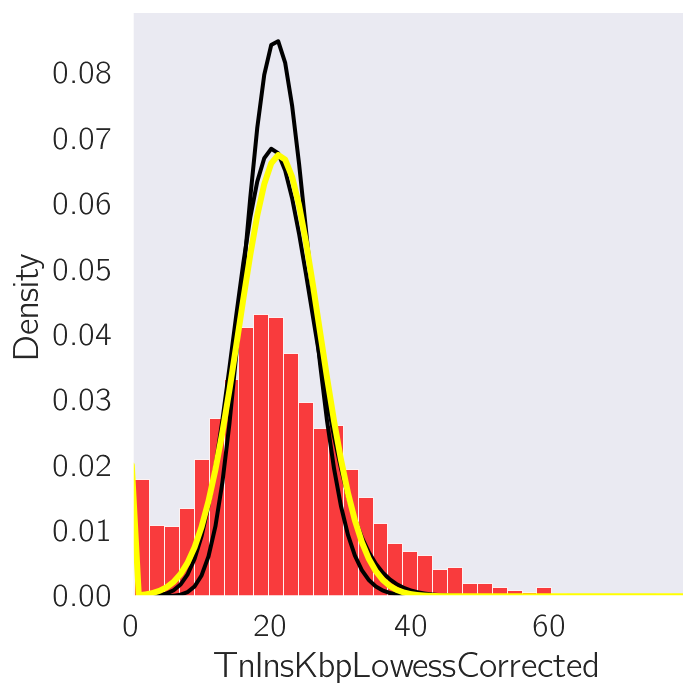

In [965]:
sns.displot(genes[col], color='red', stat='density')
plt.plot(x, ZIP(x, pi), color='black')
plt.plot(x, ZIP(x, pi, func=scipy.stats.lognorm.pdf,
                args={'s': lognorm_params[0],
                      'loc': lognorm_params[1],
                      'scale': lognorm_params[2]}),
         color='black')
plt.plot(x, ZIP(x, pi, func=scipy.stats.norm.pdf, args={'loc': mean, 'scale': genes[cond][col].std()}), color='yellow', lw=3)

plt.xlim(x.min(), x.max())

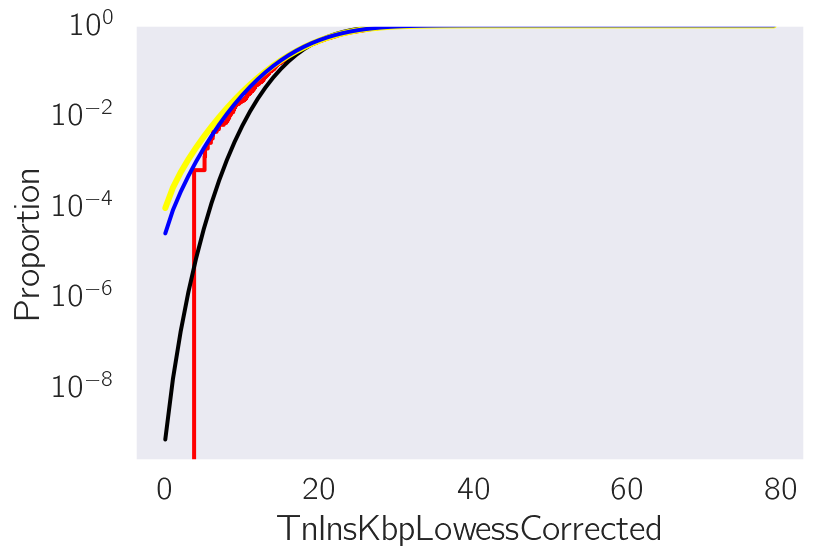

In [926]:
sns.ecdfplot(genes[cond][col], color='red', stat='proportion')
plt.plot(x, ZIP(x, 0).cumsum(), color='black')
plt.plot(x, ZIP(x, 0, func=scipy.stats.norm.pdf, args={'loc': mean, 'scale': genes[cond][col].std()}).cumsum(), color='yellow', lw=3)
plt.plot(x, ZIP(x, 0, func=scipy.stats.lognorm.pdf,
                args={'s': lognorm_params[0],
                      'loc': lognorm_params[1],
                      'scale': lognorm_params[2]}).cumsum(),
         color='blue')
plt.yscale('log')

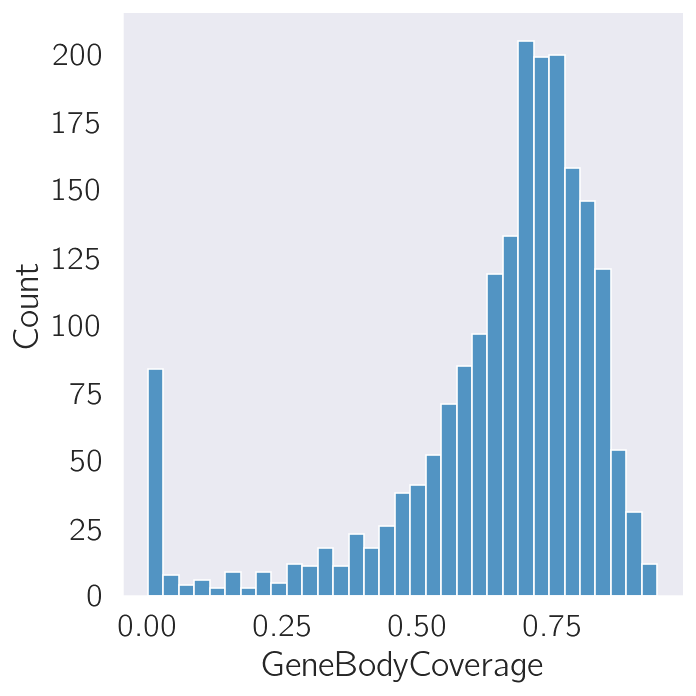

In [986]:
sns.displot(genes.GeneBodyCoverage)

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='log1pTotFreq', ylabel='GeneBodyCoverage'>

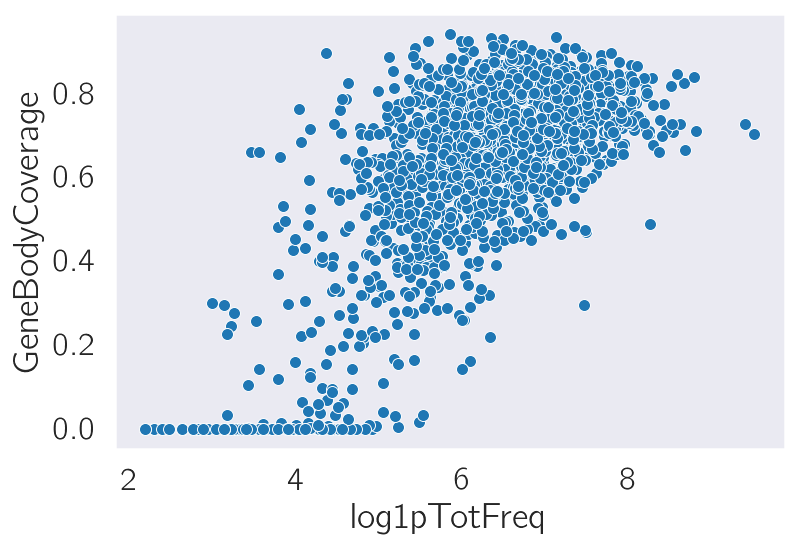

In [990]:
sns.scatterplot('log1pTotFreq', 'GeneBodyCoverage', data=genes)
# plt.xscale('log')

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


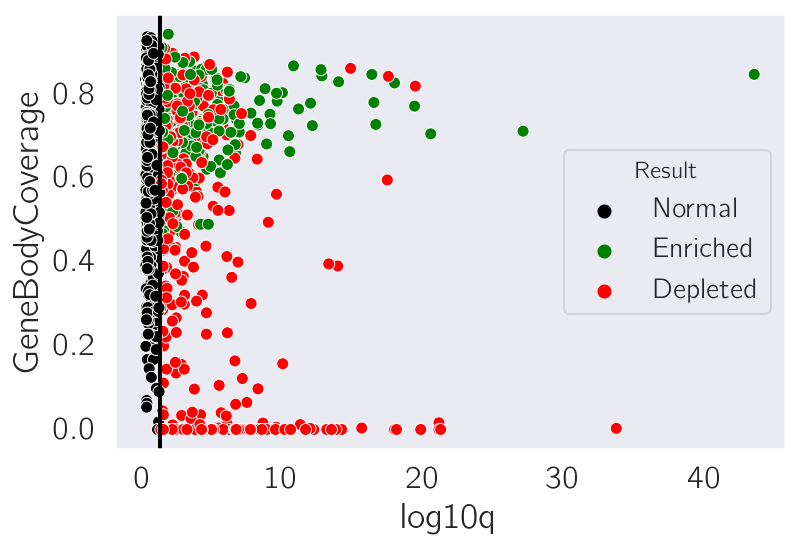

In [1009]:
sns.scatterplot('log10q', 'GeneBodyCoverage', hue="Result", palette=['Black', 'Green', 'Red'], data=genes)
plt.axvline(-np.log10(0.05), color='black')

In [993]:
genes.head()

,Gene,AvgFreq,TnMutants,TotalFreq,Var,BinSize,GenePosition,GeneBodyCoverage,TnInsKbp,log1pAvgFreq,log1pTotFreq
0,JF1,36.144737,76,2747,488.045439,3639.000000,7.096015e+05,0.718879,20.884858,3.614822,7.918629
1,XR2,44.250000,4,177,818.916667,186.000000,6.994860e+05,0.167204,21.505376,3.812203,5.181784
2,aat,27.733333,15,416,432.923810,660.000000,2.621115e+06,0.446364,22.727273,3.358058,6.033086
3,abc,35.074074,27,947,437.994302,987.000000,6.469050e+06,0.730294,27.355623,3.585574,6.854355
4,accC,41.830986,71,2970,914.228169,1372.478873,3.027952e+06,0.752845,51.731215,3.757262,7.996654
